# Plan

1) Setup \
2) Load Data \
3) Data wrangling\
4) Statistical Methods

___

# 1 | Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Forecasting_Retail_Australia"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)
# pd.set_option('display.float_format', '{:.2%}'.format)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

___

# 2 | Load Data

In [5]:
# Get Actuals from Jan 2017 to December 2022
df = pd.read_csv('Actuals_Retail_Australia_2017To2022.csv', 
                 skipfooter=1, 
                 parse_dates=['Date'], 
                 dayfirst=True, 
                 index_col=[0], 
                 engine='python')

df.rename(columns = {'Sum of Quantity' : 'Quantity'}, inplace=True)

In [6]:
# Select only B500BT17
product_ = 'B500BT17'

df = df[df["Item"].values == product_]

____

# 3 | Data Wrangling

In [7]:
df['Year'] = df.index.year 
df['Month'] = df.index.month 
df['Day'] = 1

from datetime import datetime, timedelta
df['inserted_date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df.head()

,Location,Item,Quantity,Year,Month,Day,inserted_date
Date,,,,,,,
2017-01-01,Aesop Carindale,B500BT17,1.0,2017,1,1,2017-01-01
2017-01-01,Aesop Chadstone,B500BT17,2.0,2017,1,1,2017-01-01
2017-01-01,Aesop Claremont Quarter,B500BT17,1.0,2017,1,1,2017-01-01
2017-01-01,Aesop Doncaster,B500BT17,3.0,2017,1,1,2017-01-01
2017-01-01,Aesop Emporium I,B500BT17,2.0,2017,1,1,2017-01-01


#### Group by month-year

In [8]:
result_g = df.groupby([df.inserted_date]).agg({'Quantity':sum})

result_gs = result_g[result_g.index < '2022-08-01']
result_gs.head()

,Quantity
inserted_date,
2017-01-01,1952.0
2017-02-01,1898.0
2017-03-01,2052.0
2017-04-01,2016.0
2017-05-01,1977.0


# 4 | Statistical methods

## 4.1 Moving Average

The idea behind:
The moving average model is based on the idea that future demand is similar to the recent demand we observed. With this model, we simply assume that the forecast is the average demand during the last n periods.

Limitations:
- No Trend: The model does not see any trend
- No Seasonality: The model will not properly react to seasonality
- Flat Historical Weighting: A moving average will allocate an equal weight to all the historical periods that are taken into account.

![moving avrerage formula](moving_avg_formula.png) 

Let's define a function moving_average(d, extra_periods=1, n=3) that takes three inputs:
- d: A time series that contains the historical demand
- extra_periods: The number of periods we want to forecast in the future
- n: The number of periods we will average

In [13]:
def moving_average(d, extra_periods=1, n=3):
    # Historical period length
    cols = len(d)
    # Append np.nan into the demand array to cover future periods
    d = np.append(d,[np.nan]*extra_periods)
    # Define the forecast array
    f = np.full(cols+extra_periods,np.nan)
    
    # Create all the t+1 forecast until end of historical period
    for t in range(n,cols):
        f[t] = np.mean(d[t-n:t])
    
    # Forecast for all extra periods
    f[t+1:] = np.mean(d[t-n+1:t+1])
    
    # Return a DataFrame with demand, forecast and error
    df = pd.DataFrame.from_dict({'Demand':d, 'Forecast':f, 'Error':d-f})
    
    return df

<AxesSubplot:title={'center':'Moving Average'}, xlabel='Period'>

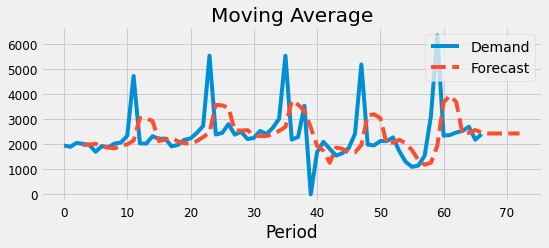

In [34]:
d = result_gs['Quantity']
df = moving_average(d, extra_periods=6, n=3)
df.index.name = 'Period'
df[['Demand', 'Forecast']].plot(figsize=(8,3), title='Moving Average', style=['-','--'])

### Demand KPI

#### Bias
The bias represents the overall direction of the historical acerage error. It measures if your forecast were on average too high or too low.

![bias formula](bias_formula.png) 

In [21]:
 def kpi(df):
        dem_ave = df.loc[df['Error'].notnull(), 'Demand'].mean()
        bias_abs = df['Error'].mean()
        bias_rel = bias_abs / dem_ave
        print('Bias: {:0.2f}, {:.2%}'.format(bias_abs,bias_rel))

In [22]:
kpi(df)

Bias: 12.35, 0.51%


#### MAPE
The Mean Absolute Percentage Error is one of the most commonly used KPIs to emasure accuracy is computed as the average of the individual absolute errors divided by the demand (each period is divided separately). To put it simply, it is the average of the percentage absolute errors.

![mape formula](mape_formula.png) 

In [23]:
 def kpi(df):
        dem_ave = df.loc[df['Error'].notnull(), 'Demand'].mean()
        bias_abs = df['Error'].mean()
        bias_rel = bias_abs / dem_ave
        print('Bias: {:0.2f}, {:.2%}'.format(bias_abs,bias_rel))
        MAPE = (df['Error'].abs()/df['Demand']).mean()
        print('MAPE: {:.2%}'.format(MAPE))

In [24]:
kpi(df)

Bias: 12.35, 0.51%
MAPE: 4195.83%


#### MAE

The Mean Absolute Error (MAE) is a very good KPI to measure forecast accuracy. As the name implies, it is the mean of the absolute error.

![mae formula](mae_formula.png) 

In [26]:
 def kpi(df):
        dem_ave = df.loc[df['Error'].notnull(), 'Demand'].mean()
        bias_abs = df['Error'].mean()
        bias_rel = bias_abs / dem_ave
        print('Bias: {:0.2f}, {:.2%}'.format(bias_abs,bias_rel))
        MAPE = (df['Error'].abs()/df['Demand']).mean()
        print('MAPE: {:.2%}'.format(MAPE))
        MAE_abs = df['Error'].abs().mean()
        MAE_rel = MAE_abs / dem_ave
        print('MAE: {:0.2f}, {:.2%}'.format(MAE_abs, MAE_rel))

In [27]:
kpi(df)

Bias: 12.35, 0.51%
MAPE: 4195.83%
MAE: 739.87, 30.83%


## 4.2 Exponential Smoothing

The idea behind:
This model assume that the future will be more or less the same as the recent past. The only pattern that this model will be able to learn from demand history is its Level.

The level is the average value around which the demand varies over time. As per below the level is a smoothed version of the demand.


![mae formula](expo_smoothing_explanation.png) 

The exponential smoothing model is slightly smarter than the moving average model, thanks to its clever weighting of the historical demand objservations

Limitations: 
- No Trend: it does not project trends
- No Seasonality: it does not recognize any seasonal pattern

Also it cannot (natively) use any external explanatory variables (pricing, marketing expenses...)

Let's define a function simple_exp_smooth() that takes three parameters:
- d: The time series to forecast
- extra_perios=1: The number of periods that need to be forecast into the future
- alpha=0.4: The smoothing alpha parameter

In [28]:
def simple_exp_smooth(d, extra_periods=1, alpha=0.4):
    
    # Historical period length
    cols = len(d)
    # Append np.nan into the demand array to cover futur periods
    d = np.append(d,[np.nan]*extra_periods)
    
    # Forecast array
    f = np.full(cols+extra_periods,np.nan)
    # initialization of first forecast
    f[1] = d[0]
    
    # Create all the t+1 forecast until end of historical period
    for t in range(2,cols+1):
        f[t] = alpha*d[t-1]+(1-alpha)*f[t-1]
    
    # Forecast for all extra periods
    for t in range(cols+1,cols+extra_periods):
        # Update the forecast as the previous forecast
        f[t] = f[t-1]
    
    df = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Error':d-f})
    
    return df

<AxesSubplot:title={'center':'Simple Smoothing'}, xlabel='Period'>

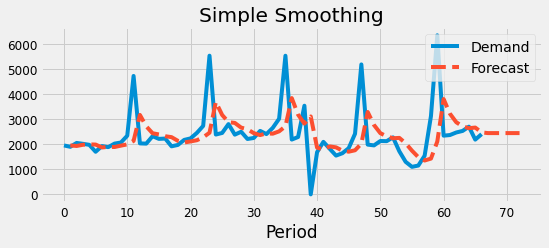

In [43]:
d = result_gs['Quantity']
df = simple_exp_smooth(d, extra_periods=6)
df.index.name = 'Period'
df[['Demand', 'Forecast']].plot(figsize=(8,3), title='Simple Smoothing', style=['-','--'])

In [30]:
kpi(df)

Bias: 18.65, 0.78%
MAPE: 4729.42%
MAE: 659.20, 27.62%


## 4.3 Double Exponential Smoothing

The idea behind:
Starting from a Exponential Smoothing that identifies the level, the double exp Smoothing can identify and project a trend.

We define the trend as the average variation of the time series level between two consecutive periods. Remember that the level is the average value around which the demand varies over time.

Just as for the level, this new model will estimate the trend based on exponential beta, giving more (or less) importance to the most recent observations.

Level and Trend will be updated after each period based on two same pieces of information: the last observation and the previous estimation of this component.

![double exp smooth formula](double_exp_smooth_formula.png) 

![double exp smooth formula](double_exp_smooth_formula2.png) 

Limitations:
- This model will assume that the trend will go on forever
- No seasonality
- Cannot take external information into account

Let's create a function double_exp_smooth() that takes d and extra periods

In [70]:
def double_exp_smooth(d, extra_periods=1, alpha=0.4, beta=0.4):
    
    
    # Historical period length
    cols = len(d)
    # Append np.nan into the demand array to cover future periods
    d = np.append(d,[np.nan]*extra_periods)
    
    # Creation of the level, trend and forecast arrays
    f,a,b = np.full((3,cols+extra_periods),np.nan)
    
    # Level and Trend initialization
    a[0] = d[0]
    b[0] = d[1] - d[0]
    
    # Create all the t+1 forecast
    for t in range(1,cols):
        f[t] = a[t-1] + b[t-1]
        a[t] = alpha*d[t] + (1-alpha)*(a[t-1]+b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*b[t-1]
    
    # Forecast for all extra periods
    for t in range(cols,cols+extra_periods):
        f[t] = a[t-1] + b[t-1]
        a[t] = f[t]
        b[t] = b[t-1]
    
    df = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Level':a, 'Trend':b, 'Error':d-f})
    
    return df

<AxesSubplot:title={'center':'Double Smoothing'}, xlabel='Period'>

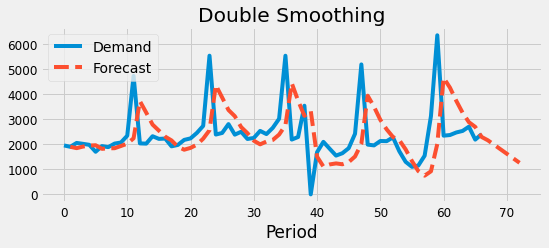

In [71]:
d = result_gs['Quantity']
df = double_exp_smooth(d, extra_periods=6)
df.index.name = 'Period'
df[['Demand', 'Forecast']].plot(figsize=(8,3), title='Double Smoothing', style=['-','--'])

In [72]:
kpi(df)

Bias: -11.87, -0.50%
MAPE: 5078.73%
MAE: 875.20, 36.67%


### Optimisation model
We will implement an optimization function exp_smooth_opti(d, extra_periods=6) that will test multiple models and return the best one.


In [74]:
def exp_smooth_opti(d, extra_periods=6):
    
    params = [] # contains all the different parameter sets
    KPIs = [] # contains the results of each model
    dfs = [] # contains all the DataFrames returned by the different models
    
    for alpha in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
        
        df = simple_exp_smooth(d, extra_periods=extra_periods, alpha=alpha)
        params.append(f"Simple Smoothing, alpha: {alpha}")
        dfs.append(df)
        MAE = df['Error'].abs().mean()
        KPIs.append(MAE)
        
        for beta in [0.05, 0.1, 0.2, 0.3, 0.4]:
            
            df = double_exp_smooth(d,extra_periods=extra_periods,alpha=alpha,beta=beta)
            params.append(f"Double Smoothing, alpha:{alpha}, beta:{beta}")
            dfs.append(df)
            MAE = df['Error'].abs().mean()
            KPIs.append(MAE)
    mini = np.argmin(KPIs)
    print(f"Best Solution found for {params[mini]} MAE of", round(KPIs[mini],2))
    
    return dfs[mini]

In [75]:
d = result_gs['Quantity']
df = exp_smooth_opti(d)

Best Solution found for Simple Smoothing, alpha: 0.05 MAE of 569.39


<AxesSubplot:title={'center':'Double Smoothing'}>

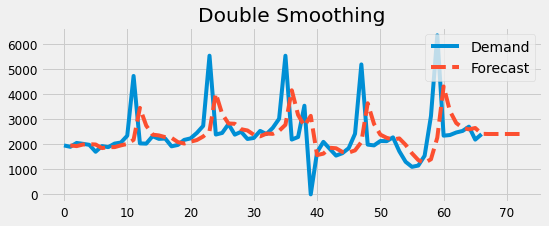

In [81]:
df[['Demand', 'Forecast']].plot(figsize=(8,3), title='Best model found', style=['-','--'])

____